$\newcommand{\Reals}{\mathbb{R}}
\newcommand{\Nats}{\mathbb{N}}
\newcommand{\PDK}{\mathbf{k}}
\newcommand{\IS}{\mathcal{X}} 
\newcommand{\FM}{\Phi} 
\newcommand{\Gram}{K} 
\newcommand{\RKHS}{\mathcal{H}}
\newcommand{\prodDot}[2]{\left\langle#1,#2\right\rangle}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}$
# Reproducing Kernel Hilbert Spaces in Machine Learning

In [2]:
from __future__ import division, print_function, absolute_import
from IPython.display import SVG, display, Image

import numpy as np, scipy as sp, pylab as pl, matplotlib.pyplot as plt, scipy.stats as stats, sklearn, sklearn.datasets
from scipy.spatial.distance import squareform, pdist, cdist

import distributions as dist #commit 480cf98 of https://github.com/ingmarschuster/distributions

/Users/ischuster/Documents/university/Promotion_NLP/software/python/distributions/distributions/linalg.py:35: UserWarning: warning: caught this exception:module 'numpy.core' has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


# Motivation: Feature engineering in Machine Learning
In ML, one classic way to handle nonlinear relations in data (non-numerical data) with linear methods is to map the data to so called features using a nonlinear function $\FM$ (a function mapping from the data to a vector space).

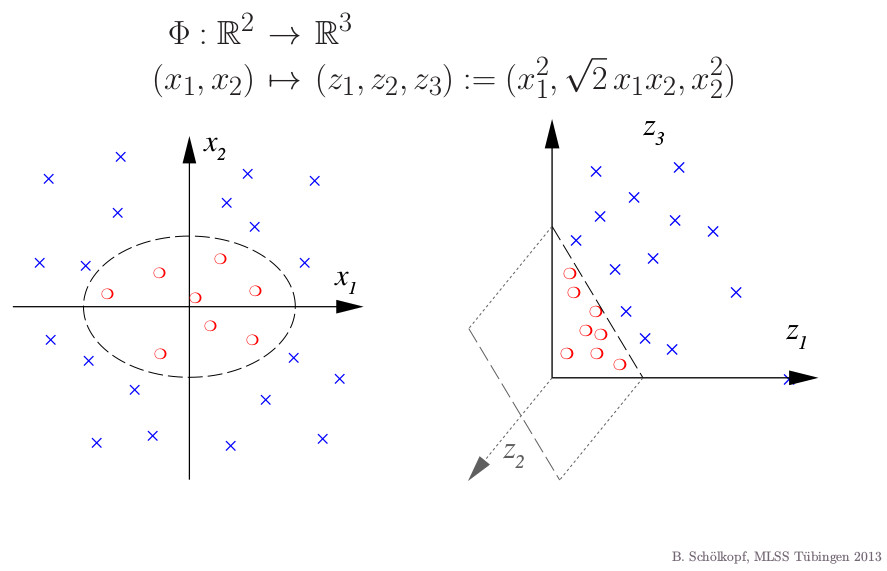

In [8]:
display(Image(filename="monomials.jpg", width=200))

In the Feature Space (the domain of $\FM$), we can then use linear algebra, such as angles, norms and inner products, inducing nonlinear operations on the Input Space (codomain of $\FM$). The central thing we need, apart from the feature space being a vector space are inner products, as they induce norms and a possibility to measure angles.

### Simple classification algorithm using only inner products
Say we are given data points from the mixture of two distributions with densities $p_0,p_1$:
$$x_i \sim w_0 p_0 + w_1 p_1$$ and labels $l_i = 0$ if $x_i$ was actually generated by $p_0$, $l_i = 1$ otherwise. A very simple classification algorithm would be to compute the mean in feature space $\mu_c = \frac{1}{N_c} \sum_{l_i = c} \FM(x_i)$ for $c \in \{0,1\}$ and assign a test point to the class which is the most similar in terms of inner product. In other words, the decision function 
$ f_d:\IS\to\{0,1\}$ is defined by
$$f_d(x) = \argmax_{c\in\{0,1\}} \prodDot{\FM(x)}{\mu_c}$$

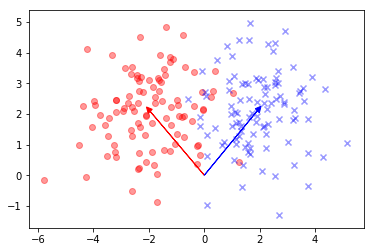

In [4]:
data = np.vstack([stats.multivariate_normal(np.array([-2,2]), np.eye(2)*1.5).rvs(100),
                  stats.multivariate_normal(np.ones(2)*2, np.eye(2)*1.5).rvs(100)])
distr_idx = np.r_[[0]*100, [1]*100]

for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    pl.scatter(*data[distr_idx==idx,:].T, c=c, alpha=0.4, marker=marker)
    pl.arrow(0, 0, *data[distr_idx==idx,:].mean(0), head_width=0.2, head_length=0.2, fc=c, ec=c)
pl.show()

Remarkably, all positive definite functions are inner products in some feature space.

**Theorem** Let $\IS$ be a nonempty set and let $\PDK:\IS\times\IS \to \Reals$, called a *kernel*. The following two conditions are equivalent:
* $\PDK$ is symmetric and *positive semi definite (psd)*, i.e. for all $x_1, \dots, x_m \in \IS$ the matrix $\Gram$ defined by with entries $\Gram_{i,j} = \PDK(x_i, x_j)$ is symmetric psd
$\FM$ is called the *Feature Map* and $\RKHS_\FM$ the *feature space*.
* there exists a map $\FM: \IS \to \RKHS_\FM$ to a hilbert space $\RKHS_\FM$ such that $$\PDK(x_i, x_j) = \prodDot{\FM(x_i)}{\FM(x_j)}_\RKHS$$


In other words, $\PDK$ computes the inner product in some $\RKHS_\FM$. We furthermore endow the space with the norm induced by the dot product $\|\cdot\|_\PDK$. From the second condition, it is easy to construct $\PDK$ given $\FM$. A general construction for $\FM$ given $\PDK$ is not as trivial but still elementary.

## Construction of the canonical feature map (Aronszajn map)

We give the canonical construction of $\FM$ from $\PDK$, together with a definition of the inner product in the new space. In particular, the feature for each $x \in \IS$ will be a function from $\IS$ to $\Reals$.
$$\FM:\IS \to \Reals^\IS\\
\FM(x) = \PDK(\cdot, x)$$
Thus for the linear kernel $\PDK(x,y)=\prodDot{x}{y}$ we have $\FM(x) = \prodDot{\cdot}{x}$ and for the gaussian kernel $\PDK(x,y)=\exp\left(-0.5{\|x-y\|^2}/{\sigma^2}\right)$ we have $\FM(x) = \exp\left(-0.5{\|\cdot -x \|^2}/{\sigma^2}\right)$.

Now $\RKHS$ is the closure of $\FM(\IS)$ wrt. linear combinations of its elements:
$$\RKHS = \left\{f: f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i) \right\} = span(\FM(\IS))$$
where $m \in \Nats, a_i \in \Reals, x \in \IS$. This makes $\RKHS$ a vector space over $\Reals$.

For $f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i)$ and $g(\cdot)=\sum_{i=1}^m' b_j \PDK(\cdot, x'_j)$ we define the inner product in $\RKHS$ as
$$\prodDot{f}{g} = \sum_{i=1}^m \sum_{i=1}^m' b_j a_i \PDK(x'_j, x_i)$$
In particular, for $f(\cdot) = \PDK(\cdot,x), g(\cdot) = \PDK(\cdot,x')$, we have $\prodDot{f}{g} = \prodDot{ \PDK(\cdot,x)}{ \PDK(\cdot,x')}=\PDK(x,x')$. This is called the *reproducing property* of the kernel of this particular $\RKHS$.
Obviously $\RKHS$ with this inner product satisfies all conditions for a hilbert space: the inner product is
* positive definite
* linear in its first argument
* symmetric

which is why $\RKHS$ is called a *Reproducing Kernel Hilbert Space (RKHS)*.

### Inner product classification algorithm is equivalent to a classification with KDEs
The naive classification algorithm we outlined earlier is actually equivalent to a simple classification algorithm using KDEs. For concreteness, let $\PDK(x,x') = { {{(2\pi )^{-N/2}\left|\Sigma \right|^{-1/2}}}\exp({-{ 0.5}(x-x' )^{\top }\Sigma ^{-1}(x-x' )}})$.

Then the mean in feature space of data from distribution $c$ with the canonical feature map is 
$$\mu_c = \frac{1}{N_c} \sum_{l_i = c} \FM(x_i) = \frac{1}{N_c} \sum_{l_i = c} \PDK(x_i, \cdot) = \frac{1}{N_c} \sum_{l_i = c} { {{(2\pi )^{-N/2}\left|\Sigma \right|^{-1/2}}}\exp({-{ 0.5}(\cdot-x_i )^{\top }\Sigma ^{-1}(\cdot-x_i )}})$$
which is just a KDE of the density $p_c$ using gaussian kernels with parameter $\Sigma$. For a test point $y$ that we want to classify, its feature is just $\PDK(y,\cdot) = { {{(2\pi )^{-N/2}\left|\Sigma \right|^{-1/2}}}\exp({-{ 0.5}(y-\cdot )^{\top }\Sigma ^{-1}(y-\cdot )}})$. Its inner product with the class mean is just the evaluation of the KDE at $y$ (because of the reproducing property). Thus each point is classified as belonging to the class for which the KDE estimate assigns highest probability to $y$.

In [5]:
class Kernel(object):
    def mean_emb(self, samps):
        return lambda Y: self.k(samps, Y).sum()/len(samps)
    
    def mean_emb_len(self, samps):
        return self.k(samps, samps).sum()/len(samps**2)
    
    def k(self, X, Y):
        raise NotImplementedError()

class FeatMapKernel(Kernel):
    def __init__(self, feat_map):
        self.features = feat_map
        
    def features_mean(self, samps):
        return self.features(samps).mean(0)
    
    def mean_emb_len(self, samps):
        featue_space_mean = self.features_mean(samps)
        return featue_space_mean.dot(featue_space_mean)
    
    def mean_emb(self, samps):
        featue_space_mean = self.features(samps).mean(0)
        return lambda Y: self.features(Y).dot(featue_space_mean)
    
    def k(self, X, Y):
        gram = self.features(X).dot(self.features(Y).T)
        return gram

class LinearKernel(FeatMapKernel):
    def __init__(self):
        FeatMapKernel.__init__(self, lambda x: x)

class GaussianKernel(Kernel):
    def __init__(self, sigma):
        self.width = sigma
    
    def k(self, X, Y=None):
        assert(len(np.shape(X))==2)
        
        # if X=Y, use more efficient pdist call which exploits symmetry
        if Y is None:
            sq_dists = squareform(pdist(X, 'sqeuclidean'))
        else:
            assert(len(np.shape(Y))==2)
            assert(np.shape(X)[1]==np.shape(Y)[1])
            sq_dists = cdist(X, Y, 'sqeuclidean')
    
        K = exp(-0.5 * (sq_dists) / self.width ** 2)
        return K

class StudentKernel(Kernel):
    def __init__(self, s2, df):
        self.dens = dist.mvt(0,s2,df)
        
    def k(self, X,Y=None):
        if Y is None:
            sq_dists = squareform(pdist(X, 'sqeuclidean'))
        else:
            assert(len(np.shape(Y))==2)
            assert(np.shape(X)[1]==np.shape(Y)[1])
            sq_dists = cdist(X, Y, 'sqeuclidean')
        dists = np.sqrt(sq_dists)
        return exp(self.dens.logpdf(dists.flatten())).reshape(dists.shape)


def kernel_mean_inner_prod_classification(samps1, samps2, kernel):
    mean1 = kernel.mean_emb(samps1)
    norm_mean1 = kernel.mean_emb_len(samps1)
    mean2 = kernel.mean_emb(samps2)
    norm_mean2 = kernel.mean_emb_len(samps2)
    
    def sim(test):
        return (mean1(test) - mean2(test))
    
    def decision(test):
        if sim(test) >= 0:
            return 1
        else:
            return 0
    
    return sim, decision



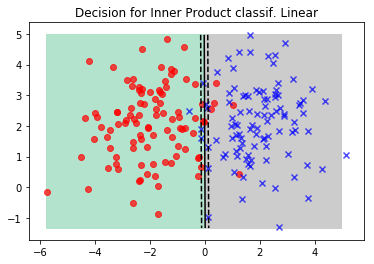

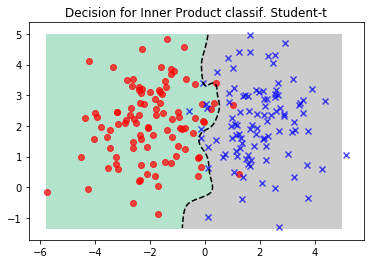

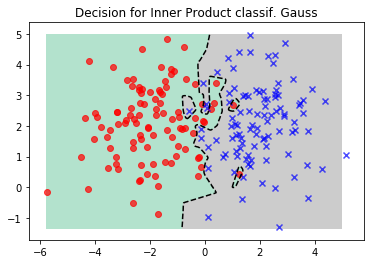

In [6]:
def apply_to_mg(func, *mg):
    #apply a function to points on a meshgrid
    x = np.vstack([e.flat for e in mg]).T
    return np.array([func(i.reshape((1,2))) for i in x]).reshape(mg[0].shape)

def plot_with_contour(samps, data_idx, cont_func, method_name, delta = 0.025, pl = pl):
    x = np.arange(samps.T[0].min()-delta, samps.T[1].max()+delta, delta)
    y = np.arange(samps.T[1].min()-delta, samps.T[1].max()+delta, delta)
    X, Y = np.meshgrid(x, y)
    Z = apply_to_mg(cont_func, X,Y)
    Z = Z.reshape(X.shape)


    # contour labels can be placed manually by providing list of positions
    # (in data coordinate). See ginput_manual_clabel.py for interactive
    # placement.
    fig = pl.figure()
    pl.pcolormesh(X, Y, Z > 0, cmap=pl.cm.Pastel2)
    pl.contour(X, Y, Z, colors=['k', 'k', 'k'],
              linestyles=['--', '-', '--'],
              levels=[-.5, 0, .5])
    pl.title('Decision for '+method_name)
    #plt.clabel(CS, inline=1, fontsize=10)
    for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
        pl.scatter(*data[distr_idx==idx,:].T, c=c, alpha=0.7, marker=marker)

    pl.show()
    
for (kern_name, kern) in [("Linear", LinearKernel()), 
                          ("Student-t", StudentKernel(0.1,10)), 
                          ("Gauss", GaussianKernel(0.1))
                         ]:
    (sim, dec) = kernel_mean_inner_prod_classification(data[distr_idx==1,:], data[distr_idx==0,:], kern)
    plot_with_contour(data, distr_idx, sim, 'Inner Product classif. '+kern_name, pl = plt)

Obviously, the linear kernel might be enough already for this simple dataset. Another interesting observation however is that the Student-t based kernel is more robust to outliers of the datasets and yields a lower variance classification algorithm as compared to using a Gaussian kernel. This is to be expected, given the fatter tails of the Student-t. Now lets look at a dataset that is not linearly separable.

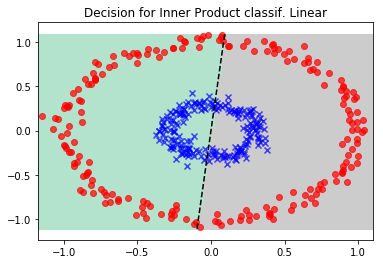

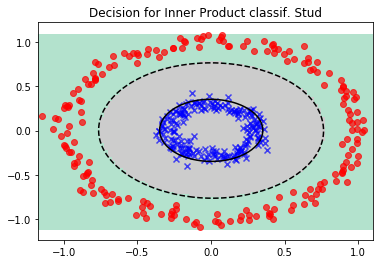

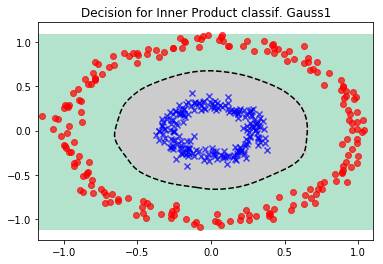

In [7]:
data, distr_idx = sklearn.datasets.make_circles(n_samples=400, factor=.3, noise=.05)

for (kern_name, kern) in [("Linear", LinearKernel()), 
                          ("Stud", StudentKernel(0.1,10)), 
                          ("Gauss1", GaussianKernel(0.1)),
                         ]:
    (sim, dec) = kernel_mean_inner_prod_classification(data[distr_idx==1,:], data[distr_idx==0,:], kern)
    plot_with_contour(data, distr_idx, sim, 'Inner Product classif. '+kern_name, pl = plt)

In this dataset, the Linear kernel is not a good choice, simply because the classes are not separable linearly in input space. Gaussian and Student-t work, and Student-t shows slightly better robustness properties.

## The kernel mean map
One of the objects we looked at, the kernel mean map is particularly interesting. In fact, for so called *characteristic* kernels, the integral
$$\mu_\PDK =  \int  \PDK(x, \cdot) \mathrm{d}p(x)$$
preserves all information about the distribution $p(x)$, like e.g. characteristic functions, while not even assuming that $x$ is numerical (remember that the only restriction on the codomain of $\PDK$ is that it be nonempty).

When we have an estimator $\widehat{\mu}_\PDK$ and a function $f \in \RKHS$, we have
$$\int  f(x) \mathrm{d}p(x) \approx \prodDot{f}{\widehat{\mu}_\PDK}$$
because of the reproducing property. In other words, integration for functions in the RKHS $\RKHS$ is just a dot product in $\RKHS$. The unfortunate restriction being that functions in the RKHS are real valued (or complex valued in the more general case).

**Lemma** If a kernel is *strictly* positive definite, it is characteristic.

Thus the Gaussian and Student-t kernel and many other kernels induced by densities will be characteristic. The embedding gives us a distance measure between distributions for free.

**Definition** The *Maximum Mean Discrepancy* of two distributions given their kernel mean embeddings $\mu_\PDK, \nu_\PDK$ is defined by
$$\mathrm{MMD}(\mu_\PDK, \nu_\PDK) = \|\mu_\PDK - \nu_\PDK\|^2_\PDK$$

Furthermore, marginalization, the chain rule and Bayes rule can all be represented as operations in an RKHS. Also, independence tests for random variables operating in a RKHS have been proposed.